In [ ]:
import torch
import sys
sys.path.append('/home/ljq/code/RingdownGapFilling')
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD





import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD
import numpy as np
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from config.config import Config
from data.waveform import *
from data.ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import *
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
from utils.SNR import compute_matched_filter_snr
import os
# def rotate_list(lst, position=2):
#     index = len(lst) // position
#     return lst[index:] + lst[:index]
SAVE_PATH_1= 'data/signal_data.npz'
SAVE_PATH_2 = 'data/signal_test_data.npz'
SAVE_PATH_noise= 'data/signal_data_with_noise.npz'
TEMP_DIR_1 = 'data/temp_files'
TEMP_DIR_2 = 'data/temp_files2'
os.makedirs(TEMP_DIR_1, exist_ok=True)  # 创建临时文件目录
scale=Config.scale
samp_freq=Config.samp_freq
N=round(samp_freq/Config.f_step)
time_vec=1/samp_freq*np.arange(0,N,1)
Noises=True
num_sigs=2
SNR=5

def generate_single_data(i):
    # 生成单个数据的代码
    M=[]
    ratio=[]
    R=[]
    for j in range(num_sigs):  
        
        Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
        M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
        R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
        signal_length = Config.signal_length

        para = [Mtot, M_ratio, R_shift]
        freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
        f_sf = sf(freq_ifft, para, para_dw, para_dtau)
        if j==0:
            st=Ga.Freq_ifft(f_sf)*Config.zoom_factor
        #给信号进行随机循环
        elif np.random.rand() > 0.3:
            
            shift=np.random.randint(0,signal_length//Config.signal_to_gap_length_ratio//2)
            
            st +=np.roll(Ga.Freq_ifft(f_sf)*Config.zoom_factor,shift) 
            
        M=np.append(M,Mtot)
        ratio=np.append(ratio,M_ratio)
        R=np.append(R,R_shift)
        paras= [M,ratio, R]
        # 在函数返回前修改
        paras = np.array(paras, dtype=np.float32)  # 先合并为单个NumPy数组
    

        

    if Noises:
        
        index = int(1/2*len(st))
        st=np.concatenate((st[index:], st[:index]))
        PSD=psd_interp_func(freq_ifft)
        out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
        
        #print(len(out_noise[0]))
        start1=int(1/2*(len(out_noise[0])-signal_length))
        start2=int(1/2*(len(st)-signal_length))+np.random.randint(0,signal_length//Config.signal_to_gap_length_ratio)-signal_length//Config.signal_to_gap_length_ratio//2
        #print(len(out_noise[0][start:start+signal_length]))
        signal = st[start2:start2+signal_length]
        signal=torch.tensor(signal)
        signal=torch.real(signal)
        
        noise=out_noise[0][start1:start1+signal_length]
        noise=torch.tensor(noise)
        noise=torch.real(noise)
        if np.random.rand() > 0.9:
            #生成全是0的信号
            signal=torch.zeros(signal.shape)
            
        data=signal+noise
        return signal,noise,data, torch.from_numpy(paras)

    else:
        original_signal = st[:signal_length]
        original_signal = torch.tensor(original_signal, dtype=torch.float32)
        original_signal = torch.real(original_signal)
        return original_signal, torch.tensor(paras, dtype=torch.float32)

def generate_data(num_samples,TEMP_DIR, SAVE_PATH):
   
    """生成指定数量的样本数据，支持断点续传
    
    Args:
        num_samples: 需要生成的总样本数量
        
    Returns:
        Tuple: (signals, conditions) 全部样本数据
    """
    

    # 1. 初始化临时目录
    os.makedirs(TEMP_DIR, exist_ok=True)
    
    # 2. 准确计算已有样本数（忽略非样本文件）
    existing_samples = len([
        f for f in os.listdir(TEMP_DIR) 
        if f.startswith('sample_') and f.endswith('.npz')
    ])
    
    # 3. 计算需要生成的数量
    start_index = existing_samples
    remaining_samples = max(0, num_samples - start_index)
    
    # 4. 显示进度信息
    print(f"当前进度: {start_index}/{num_samples} | 待生成: {remaining_samples}")

    # 5. 生成缺失样本
    if remaining_samples > 0:
        try:
            with Pool(cpu_count()) as pool:
                results = tqdm(
                    pool.imap_unordered(generate_single_data, range(start_index, num_samples)),
                    #pool.imap_unordered(generate_single_data_with_noise, range(start_index, num_samples)),
                    total=remaining_samples,
                    desc="生成样本"
                )
                if Noises:
                    print('generate data with noise')
                    for i, (signal, noise, data, condition) in enumerate(results):
                        # 6. 实时保存每个样本
                        np.savez(
                            os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                            signal=signal.numpy(),
                            noise=noise.numpy(),
                            data=data.numpy(),
                            condition=condition.numpy()
                        )
                else:
                    print('generate data without noise, SNR=',SNR)
                    for i, (signal, condition) in enumerate(results):
                        # 6. 实时保存每个样本
                        np.savez(
                            os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                            signal=signal.numpy(),
                            condition=condition.numpy()
                    )
        except Exception as e:
            print(f"生成过程中出错: {str(e)}")
            raise RuntimeError("数据生成失败，请检查参数设置")
    
    # 7. 返回当前内存中的所有数据（可选）
    # 注意：对于大数据集建议使用 combine_data() 单独处理
    return combine_data(TEMP_DIR, SAVE_PATH)  # 或者 return None 仅执行生成操作

def combine_data(TEMP_DIR=TEMP_DIR_1, SAVE_PATH=SAVE_PATH_1):
    """合并所有样本数据并返回完整数据集"""
    try:
        # 获取并按序号排序样本文件
        sample_files = sorted(
            [f for f in os.listdir(TEMP_DIR) if f.startswith('sample_') and f.endswith('.npz')],
            key=lambda x: int(x.split('_')[1].split('.')[0])
        )
        
        if not sample_files:
            raise ValueError("未找到任何样本文件")
        if Noises:
            signals, noises,datas, conditions = [], [],[], []
            for f in tqdm(sample_files, desc="加载样本"):
                data = np.load(os.path.join(TEMP_DIR, f))
                signals.append(torch.tensor(data['signal']))
                noises.append(torch.tensor(data['noise']))
                datas.append(torch.tensor(data['data']))
                conditions.append(torch.tensor(data['condition']))
            #检查conditions是否为空
            if len(conditions)==0:
                raise ValueError("conditions为空")
            # 合并数据
            signals = torch.stack(signals)
            noises = torch.stack(noises)
            datas = torch.stack(datas)
            conditions = torch.stack(conditions)
            
            # 保存完整数据集
            np.savez(SAVE_PATH, signals=signals.numpy(), noises=noises.numpy(),datas=datas.numpy(), conditions=conditions.numpy())
            print(f"已合并 {len(signals)} 个样本到 {SAVE_PATH}")
            
            return signals, noises,datas, conditions
        else:
            signals, conditions = [], []
            for f in tqdm(sample_files, desc="加载样本"):
                data = np.load(os.path.join(TEMP_DIR, f))
                signals.append(torch.tensor(data['signal']))
                conditions.append(torch.tensor(data['condition']))
            
            # 合并数据
            signals = torch.stack(signals)
            conditions = torch.stack(conditions)
            
            # 保存完整数据集
            np.savez(SAVE_PATH, signals=signals.numpy(), conditions=conditions.numpy())
            print(f"已合并 {len(signals)} 个样本到 {SAVE_PATH}")
            
            return signals, conditions
        
    except Exception as e:
        print(f"合并数据时出错: {str(e)}")
        raise

signal_length=Config.signal_length


data = np.load('/home/ljq/code/RingdownGapFilling/data/signal_noise_gaps_HugeRangeParas.npz')
#data = np.load('data/test_signal_data.npz')
signals = data['signals']*5
noises = data['noises']
datas= data['datas']
conditions = data['conditions']
signals= torch.tensor(signals).float()
noises= torch.tensor(noises).float()
datas= torch.tensor(datas).float()
conditions= torch.tensor(conditions).float()
print("signals.shape",signals.shape)    
print("noises.shape",noises.shape)
print("datas.shape",datas.shape)
#绘制一个信号和噪声的例子
import matplotlib.pyplot as plt
import numpy as np
# plt.plot(noises[0], label='Noise')
# plt.plot(signals[0], label='Signal')

# plt.show()

from config.config import Config
gap_size = signal_length//Config.signal_to_gap_length_ratio//2

masks =generate_continuous_mask(signals.shape[0], signal_length, gap_size,start=int(1/2*Config.signal_length))
masks2=generate_continuous_mask(signals.shape[0], signal_length, gap_size,start=int(1/2*Config.signal_length)+gap_size)
#     conditions.append(condition)
from utils.noise import *

#数据预处理

#gap_size = signal_length//Config.signal_to_gap_length_ratio

masked_signals = []
mask_1d=  []
signals_copy=signals 
signals,_,_=normalize(signals)
for i in range(signals_copy.size(0)):
    masked_signal = np.copy(signals_copy[i])+noises[i]
    if np.random.rand() > 0.0:
        masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    #设置随机数
    if np.random.rand() > 0.7:
        masked_signal[~masks2[i].numpy()] = 0

    masked_signal[~masks2[i].numpy()]=0
    # #绘制前几个masked信号
    # if i< 10:
    #     print(masks[i].numpy())
    #     plt.plot(masked_signal, label='Masked Signal')
    #     plt.legend()
    #     plt.show()

    
    masked_signals.append(masked_signal)
    #print(masks[i].numpy()*masks2[i].numpy())
    mask_1d.append(np.logical_not(masks[i].numpy()*masks2[i].numpy()))
    #print("mask_1d[i]",mask_1d[i])



masked_signals = torch.tensor(masked_signals).float()
masked_datas=masked_signals
#masked_datas_copy,_,_=normalize(masked_datas)
# whitened_masked_datas=[]
# whitened_signals=[]
# # for i in range(10):
# #     plt.plot(signals_copy[i], label='Masked Signal')
# #     plt.legend()
# #     plt.show()
# for i in range(signals_copy.size(0)):
#     masked_data=np.copy(masked_datas[i])
#     if i<10:
#         plt.plot(masked_data, label='Masked Signal')
#         plt.legend()
#         plt.show()
#     whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=psd_interp_func,highpass=2e-3)
#     if i<10:
#         plt.plot(whitened_masked_data, label='Masked Signal')
#         plt.legend()
#         plt.show()
#     whitened_masked_datas.append(whitened_masked_data)
#     whitened_signal,_,_=whiten(signals_copy[i], sample_rate=2,psd=psd_interp_func,highpass=2e-3)
#     whitened_signals.append(whitened_signal)

# for i in range(10):
#     plt.plot(whitened_masked_datas[i], label='Masked Signal')
    
#     plt.legend()
#     plt.show()
mask_datas_copy=masked_datas
masked_datas,_,_=normalize(masked_datas)



processed_signals = []
processed_masked_datas = []
from model.QTranTimeMixerMod import *
from dataset.dataset import QSpecDataset
qt=QTransformModule()
Specs=[]


i=0
for Signal, masked_signal,masked_data,mask_data_copy in zip(signals_copy, masked_datas,masked_datas,mask_datas_copy):
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(Signal)
    segmented_signal = segment_signal(transformed_signal)
    
    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal(transformed_masked_signal)

    processed_signals.append(segmented_signal)
    processed_masked_datas.append(segmented_masked_signal)
    
    
    spec= qt(mask_data_copy)
    Specs.append(spec)

    print(i)
    i+=1
    
print(1)






/home/ljq/miniconda3/envs/gw_ml_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


signals.shape torch.Size([10000, 1056])
noises.shape torch.Size([10000, 1056])
datas.shape torch.Size([10000, 1056])


/tmp/ipykernel_259237/2789707275.py:443: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/ljq/pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  masked_signals = torch.tensor(masked_signals).float()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [2]:
print("processed_signals.shape",processed_signals[0][0])

processed_signals.shape [[-1.55342711e-29  1.88791254e-29  1.40206442e-31 ...
   1.74881165e-29  6.68970713e-30 -1.89273684e-29]
 [ 8.24152631e-31  6.75403093e-30 -5.41930581e-30 ...
   6.18503900e-30  6.24891556e-30 -9.29864932e-30]
 [ 3.56998800e-30  1.08225309e-29 -6.10274951e-30 ...
  -5.62045556e-31 -9.78716314e-31 -4.49516638e-30]
 ...
 [-9.91604453e-30  1.67589759e-30  9.83812938e-30 ...
  -1.13809369e-29 -9.67650624e-30  1.51323280e-29]
 [-1.60908016e-29 -2.03192643e-30  1.38356701e-29 ...
  -9.61645334e-30 -5.77710861e-30  1.05049307e-29]
 [ 4.52506597e-31 -9.54042048e-30  2.01231411e-30 ...
   1.31883715e-27  1.26726527e-27 -1.66113788e-27]]


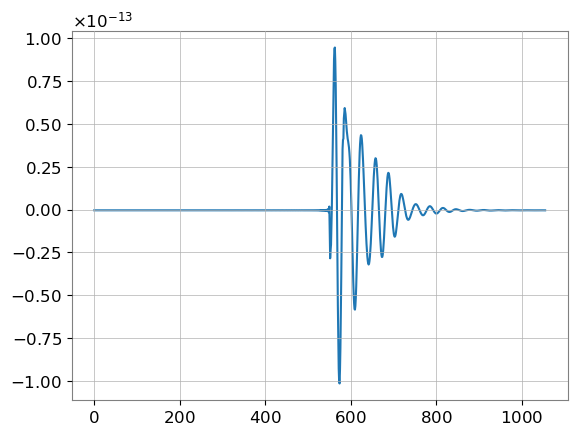

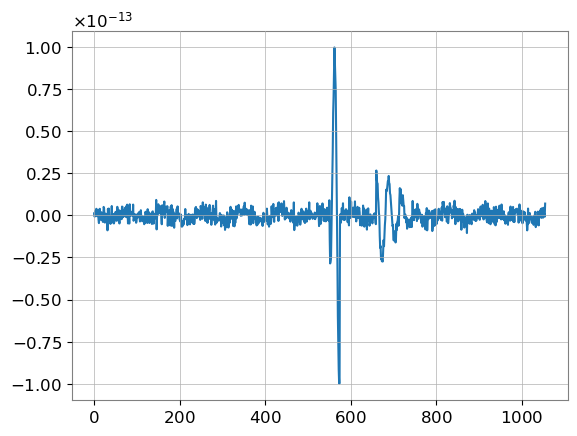

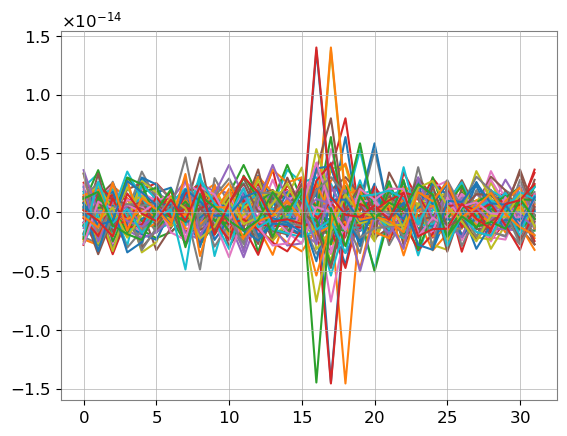

In [8]:
plt.plot(signals[0], label='nor_signal')
plt.show()
plt.plot(masked_datas[0], label='masked_signal')
plt.show()
plt.plot(processed_masked_datas[0][0], label='masked_signal')
plt.show()

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm  # 用于显示进度条
from dataset.dataset import QSpecDataset
from dataset.dataset import GWSignalDataset
from dataset.dataset import load_data_with_progress
class QSpecDataset(Dataset):
    def __init__(self, qt):
        self.qt = self._ensure_tensor(qt)
        self.total_len = len(self.qt)  # 获取数据集的总长度
    
    def __len__(self):
        return len(self.qt)
    
    def _ensure_tensor(self, data) -> torch.Tensor:
        """将输入转换为张量，支持列表、NumPy数组或已存在的张量"""
        if not isinstance(data, torch.Tensor):
            try:
                # 转换时保留原始数据类型（若需调整类型，可在此指定 dtype）
                if isinstance(data, list):
                    data = np.array(data)
                tensor = torch.as_tensor(data)
                return tensor
            except Exception as e:
                raise ValueError(f"数据无法转换为张量: {type(data)} -> {e}")
        return data

    def _to_cpu(self):
        """确保所有张量位于CPU（避免混用GPU张量）"""
        self.qt = self.qt.cpu()

    def __getitem__(self, idx):
        #每次读取一个数据项时，打印进度
        if idx % (self.total_len // 10) == 0:  # 每读取 10% 数据时显示一次进度
            print(f"加载数据进度: {idx}/{self.total_len}")
        
        return self.qt[idx]

def load_data_with_progress(dataset):
    # 使用 tqdm 显示进度条
    for idx in tqdm(range(len(dataset))):
        dataset[idx]

# 假设你的数据集已经加载到 `data` 变量中
# 例如 data = np.random.randn(10000, 256)
Spec_dataset = QSpecDataset(Specs)

# 加载数据并显示进度
load_data_with_progress(Spec_dataset)

dataset = GWSignalDataset(signals,mask_1d,processed_masked_datas, conditions)
#Spec_dataset=QSpecDataset(Specs)

print("Specs[0].shape",Specs[0].shape)
import torch



# 保存 dataset
torch.save(dataset, '/home/ljq/code/RingdownGapFilling/dataset/train_dataset_signal_data_noise_gaps_HugeRangeParas.pth')
torch.save(Spec_dataset, '/home/ljq/code/RingdownGapFilling/dataset/train_dataset_signal_data_noise_gaps_HugeRangeParas_Spec.pth')


100%|██████████| 10000/10000 [00:00<00:00, 1018875.77it/s]


加载数据进度: 0/10000
加载数据进度: 1000/10000
加载数据进度: 2000/10000
加载数据进度: 3000/10000
加载数据进度: 4000/10000
加载数据进度: 5000/10000
加载数据进度: 6000/10000
加载数据进度: 7000/10000
加载数据进度: 8000/10000
加载数据进度: 9000/10000
Specs[0].shape torch.Size([2, 16, 264])


In [5]:
import torch 
import sys
sys.path.append('/home/ljq/code/RingdownGapFilling')
from dataset.dataset import *
# 加载保存的 Dataset
dataset = torch.load('/home/ljq/code/RingdownGapFilling/dataset/train_dataset_signal_data_noise_gaps_HugeRangeParas.pth',weights_only=False)
Spec_dataset=torch.load('/home/ljq/code/RingdownGapFilling/dataset/train_dataset_signal_data_noise_gaps_HugeRangeParas_Spec.pth',weights_only=False)

dataset= CombinedDataset(dataset, Spec_dataset)


import torch
import torch.nn 
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
#from model.mymodel_2 import MaskedConditionalGapFiller

from model.DGFmodel import *
from trainer.trainer_pre_finetune import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset=new_dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])




batch_size = Config.batch_size


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取一个批次的数据
targets,mask_1d,inputs, conditions,_ = next(iter(train_loader))

#打印形状
# print(f'Inputs shape: {inputs.shape}')  
# print(f'Targets shape: {targets.shape}')  
# print(f'Conditions shape: {conditions.shape}')  

import matplotlib.pyplot as plt

# 可视化第一个批次中的前几个样本
# num_samples_to_plot = 3  # 要绘制的样本数量
# for i in range(num_samples_to_plot):
#     plt.figure(figsize=(10, 4))
#     plt.plot(inputs[i].cpu().numpy(), label='Input (Masked)')
#     plt.plot(targets[i].cpu().numpy(), label='Target (Original)')
#     plt.title(f'Sample {i+1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Signal Value')
#     plt.legend()

#     plt.show()

print("targets.shape:",targets.shape)
print("inputs.shape:",inputs.shape)
print("mask_1d.shape:",mask_1d.shape)

SAVE_PATH = '/home/ljq/code/RingdownGapFilling/saved_models/noise/lowSNR/model_with_noise_gaps_HugeRangeParas'
# 定义模型  



targets.shape: torch.Size([16, 1056])
inputs.shape: torch.Size([16, 8, 32, 64])
mask_1d.shape: torch.Size([16, 1056])


In [7]:
model = DGF().to(device)
train_the_model(
    model,
    train_loader,
    val_loader,
    num_epochs=Config.num_epochs,
    learning_rate=Config.learning_rate,
    save_path= SAVE_PATH,
    device=device,
    save_freq=10
)

🔁 Entering finetuning stage...
200


Epoch 1/200: 100%|██████████| 500/500 [00:34<00:00, 14.63it/s]
/home/ljq/pytorch/torch/optim/lr_scheduler.py:205: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/200], Training Loss: 29.5184, Validation Loss: 29.5858


Epoch 2/200: 100%|██████████| 500/500 [00:31<00:00, 16.04it/s] 


Epoch [2/200], Training Loss: 29.5191, Validation Loss: 29.5851


Epoch 3/200: 100%|██████████| 500/500 [00:30<00:00, 16.18it/s]


Epoch [3/200], Training Loss: 29.5194, Validation Loss: 29.5845


Epoch 4/200: 100%|██████████| 500/500 [00:29<00:00, 16.75it/s] 


Epoch [4/200], Training Loss: 29.5212, Validation Loss: 29.5838


Epoch 5/200: 100%|██████████| 500/500 [00:30<00:00, 16.13it/s]


Epoch [5/200], Training Loss: 29.5189, Validation Loss: 29.5831


Epoch 6/200: 100%|██████████| 500/500 [00:32<00:00, 15.22it/s] 


Epoch [6/200], Training Loss: 29.5163, Validation Loss: 29.5824


Epoch 7/200: 100%|██████████| 500/500 [00:33<00:00, 15.15it/s]


Epoch [7/200], Training Loss: 29.5125, Validation Loss: 29.5818


Epoch 8/200: 100%|██████████| 500/500 [00:30<00:00, 16.60it/s] 


Epoch [8/200], Training Loss: 29.5142, Validation Loss: 29.5811


Epoch 9/200:  43%|████▎     | 217/500 [00:11<00:15, 18.74it/s] 


KeyboardInterrupt: 